In [1]:
import scanpy as sc
import scanpy.external as sce
#sc.logging.print_versions()
#sc.logging.print_memory_usage()
#sc.settings.verbosity = 2
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

In [ ]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz


# Load data

In [2]:
adata = sc.read_h5ad('backups_JZ_2022/kidney_v1_wo_dblt1_batch_corrected_50693x2000_220127_09h59.h5ad')    

In [3]:
adata = adata.raw.to_adata()

In [4]:
adata

AnnData object with n_obs × n_vars = 50693 × 33538
    obs: 'library', 'total_counts', 'pct_counts_mito', 'library2', 'sample', 'patient', 'pT stage', 'seq_date', 'beads', 'operation', 'sex', 'tumor size, mm', 'age', 'tissue', 'necrosis', 'doublet_score', 'potential_doublet', 'top3pct_dbtl_score', 'top5pct_dbtl_score', 'top10pct_dbtl_score', 'closest_JZ_kidney', 'closest_JZ_kidney_hvg', 'removed_as_RBC', 'louvain_resolution_30.0', 'louvain_resolution_50.0', 'louvain_resolution_60.0', 'louvain_resolution_80.0', 'removed_as_dblt1', 'n_counts'
    uns: 'X_lin_cptt', 'X_log_z', 'beads_colors', 'draw_graph', 'neighbors', 'pca', 'sample_colors', 'seq_date_colors', 'tissue_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap'

In [15]:
#load the newest obs with doublet and RBC removal
filename = 'backups_JZ_2022/wo_dblt2_obs_info_50693x28_220127_15h52.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

In [16]:
obs['removed_as_dblt2'].sum()

457

In [17]:
adata.obs = obs

In [23]:
no_dblt_no_rbc = ~(adata.obs['removed_as_dblt2'].astype(bool).values)

In [25]:
no_dblt_no_rbc.sum()

50236

In [26]:
adata.obs['no_dblt_no_rbc'] = no_dblt_no_rbc

In [27]:
adata.obs['no_dblt_no_rbc']

2          True
19         True
363        True
433        True
444        True
           ... 
4865536    True
4865584    True
4865642    True
4865726    True
4866011    True
Name: no_dblt_no_rbc, Length: 50693, dtype: bool

In [28]:
cell_mask = adata.obs['no_dblt_no_rbc'].astype(bool).values

In [30]:
cell_mask.sum()

50236

# Normalize counts

In [14]:
#save not normalized counts as adata.raw, can normalize any time if needed
adata.raw = adata

In [15]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)


In [16]:
adata.X.sum(axis = 1)


matrix([[10000.001],
        [10000.   ],
        [10000.001],
        ...,
        [ 9999.999],
        [ 9999.999],
        [ 9999.999]], dtype=float32)

## Select cells to keep, log-transform and z-score, choose parameters for graph construction that will be used for both SPRING (Weinreb et al., 2018) and UMAP

In [21]:
cdata = adata[cell_mask].copy() # not all cells in this case

In [23]:

# save a copy of data before taking the log:
cdata.layers['X_lin_cptt'] = cdata.X.copy() # for X linear counts-per-10-thousand

# log transform
sc.pp.log1p(cdata)

# zscore
sc.pp.scale(cdata)

# keep a copy of the data:
cdata.layers['X_log_z'] = cdata.X.copy()

In [24]:
cdata.layers['X_lin_cptt'].sum(axis=1)

matrix([[10000.001],
        [10000.   ],
        [10000.001],
        ...,
        [ 9999.999],
        [ 9999.999],
        [ 9999.999]], dtype=float32)

In [25]:


# chose a name for the spring subplot
plot_name = 'clean_kidney'

# chose dataset for selecting abundant and variable genes
# here I use linear counts-per-10k

E = cdata.layers['X_lin_cptt']

# in an attempt to be more organized I keep a log of spring parameter and intermediate data structures used in
# the form of an unstructured annotation as part of an AnnData object.

srz.start_spring_params(cdata,plot_name)

# print the newly created dictionary, also define a variable to access it faster:
pdict = cdata.uns['spring_params'][plot_name]
pdict

{'k': 5,
 'cell_mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'min_counts': 3,
 'min_cells': 3,
 'base_ix': array([    0,     1,     2, ..., 50233, 50234, 50235]),
 'num_pc': 20,
 'plot_name': 'clean_kidney'}

In [26]:
# overwrite some of the parameters for SPRING
pdict['cell_mask'] = cell_mask # record which cell out of all were used
pdict['k'] = 10

pdict['min_counts'] = 15
pdict['min_cells'] = 20
pdict['embedding'] = 'umap'

print(len(pdict['base_ix']))

50236


<span style="color:red">
Important note:

This notebook was ran multiple times with different parameters to obtain the optimal representation.
The final embedding version presented in the paper was constructed with parameters
pdict['min_counts'] = 15
pdict['min_cells'] = 25
   </span>

### Gene selection criteria

In [27]:
# avoid genes starting with
toavoid = ['MT-','RPS','RPL','MRPL','MRPS']
for i in toavoid:
    print(i)
    print([g for g in adata.var_names if g.startswith(i)])
    print()
    print()

MT-
['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


RPS
['RPS6KA1', 'RPS8', 'RPS27', 'RPS6KC1', 'RPS7', 'RPS27A', 'RPSA', 'RPS3A', 'RPS23', 'RPS14', 'RPS18', 'RPS10-NUDT3', 'RPS10', 'RPS12', 'RPS6KA2', 'RPS6KA2-AS1', 'RPS6KA3', 'RPS4X', 'RPS6KA6', 'RPS20', 'RPS6', 'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS6KB2-AS1', 'RPS3', 'RPS25', 'RPS24', 'RPS26', 'RPS29', 'RPS6KL1', 'RPS6KA5', 'RPS27L', 'RPS17', 'RPS2', 'RPS15A', 'RPS6KB1', 'RPS21', 'RPS15', 'RPS28', 'RPS16', 'RPS19', 'RPS11', 'RPS9', 'RPS5', 'RPS4Y1', 'RPS4Y2', 'RPS19BP1']


RPL
['RPL22', 'RPL11', 'RPL5', 'RPL31', 'RPL37A', 'RPL32', 'RPL15', 'RPL14', 'RPL29', 'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-AS1', 'RPL34', 'RPL37', 'RPL26L1', 'RPL10A', 'RPL7L1', 'RPL36A', 'RPL36A-HNRNPH2', 'RPL39', 'RPL10', 'RPL7', 'RPL30', 'RPL8', 'RPL35', 'RPL12', 'RPL7A', 'RPLP2', 'RPL27A', 'RPL41', 'RPL6', 'RPLP0', 'RPL21', 'RPL10L', 'RPL36AL', 'RPL4', 'RPLP1

In [28]:
# genes to exclude:
exclude_gene_names = []
for j in toavoid:
    exclude_gene_names.append([i for i in adata.var_names if i.startswith(j)])
exclude_gene_names = rz.flatten_list_of_lists(exclude_gene_names)

pdict['gene_names_excluded'] = exclude_gene_names
print('%d genes excluded based on name'%len(exclude_gene_names))


##########################################################################################

# filter on abundance:
pdict['abundant_gene_mask'] = srz.filter_abund_genes(
                                                     E[pdict['base_ix'],:],
                                                     pdict['min_counts'],
                                                     pdict['min_cells']
                                                    )

197 genes excluded based on name
12680 genes passing abundance filter


In [29]:
# combine gene filters so far
undesired = list(pdict['gene_names_excluded'])+\
            list(cdata.var_names[~pdict['abundant_gene_mask']])

print(len(undesired))
undesired = list(set(undesired))
print(len(undesired))

# boolean mask
combmask = ~np.in1d(cdata.var_names,undesired)
print(combmask.sum(),'surviving genes so far')

21055
21041
12497 surviving genes so far


In [30]:
# calculate v score (Klein et al., 2015, see equation S4 and S13) for all non-zero genes
# the function automatically removes genes with zero expression, but better
# to get rid of these in advance at this point.

isexpr = np.array(E[pdict['base_ix'],:].sum(axis=0))[0]>0
print('%d genes with non-zero expression'%sum(isexpr))
pdict['v_score_dict'] = srz.vscores(E[pdict['base_ix'],:][:,isexpr])

# print the number of genes with v scores above mode
# these but not more can be considered variable

maxvar = pdict['v_score_dict']['var_gene_mask'][combmask[isexpr]].sum()
print("Out of the surviving genes, %d have a v-score above mode"%maxvar)

27996 genes with non-zero expression
Out of the surviving genes, 10513 have a v-score above mode


In [31]:
# out of the surviving genes, select a fix number of most variable ones
# this is one of the possible strategies
nrvar = 2000
pdict['nr_var_genes'] = nrvar

# place v score and gene names into a temporary pd.Series for convenience:
v = pd.Series(pdict['v_score_dict']['v_scores'],index=cdata.var_names[isexpr])


# get the names of the top most variable genes:
pdict['genes_used'] = v[combmask[isexpr]].sort_values(ascending=False)[:nrvar].index

# plot a v score vs mean plot with genes used further colored in red
ff = pdict['v_score_dict']['ff_gene']
mu = pdict['v_score_dict']['mu_gene']
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


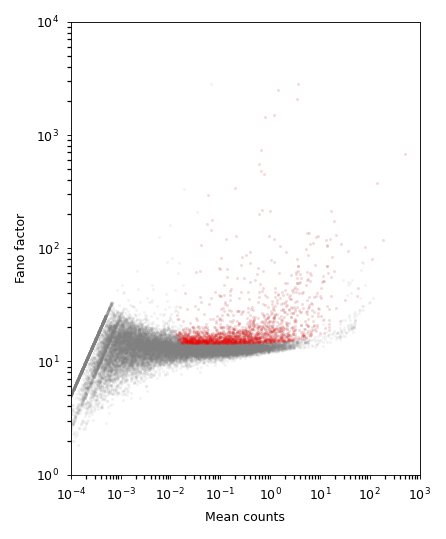

In [32]:
# check scatter
s = 2
plt.figure(figsize=(3,4))
plt.scatter(mu,ff,lw=0,color='0.5',alpha=0.1,s=s)
plt.scatter(mu[finalmask[isexpr]],ff[finalmask[isexpr]],lw=0,color='r',alpha=0.1,s=s)
plt.xscale('log');
plt.yscale('log');
plt.xlim(0.0001,1000)
plt.ylim(1,10000)
plt.xlabel('Mean counts')
plt.ylabel('Fano factor');
#plt.savefig(project_dir, dpi = 600)

### Apply gene filter and perform PCA

In [33]:
# leave only genes defined as variable, overwrite
print(cdata.shape)
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])
cdata = cdata[:,finalmask]
print(cdata.shape)

(50236, 33538)
(50236, 2000)


In [34]:
# Z score was calculated already
Z = cdata.X.copy()

In [35]:
# find the number of non-random PCs
d = srz.find_num_pc(Z[pdict["base_ix"],:],sparse=False)

calculating the first 200 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
1 	 71 	 0.63 min.
2 	 72 	 1.15 min.
3 	 72 	 1.69 min.
4 	 71 	 2.26 min.
5 	 72 	 2.79 min.
6 	 72 	 3.32 min.
7 	 71 	 3.88 min.
8 	 72 	 4.43 min.
9 	 72 	 5.00 min.
10 	 71 	 5.52 min.


In [36]:
# record results to log:
pdict['num_pc'] = d['num_pc']
pdict['eigenvectors'] = d['pca'].components_
pdict['eigenvalues'] = d['pca'].explained_variance_


print(d['num_pc'])


71


In [37]:
# apply dimensionality reduction on Z (get principle components)
# note, that eigenvalues can be calculated for base_ix only
# make sure to provide a dense matrix Z

P = pdict['eigenvectors'][:pdict['num_pc'],:].dot(Z.T).T
print(P.shape)

(50236, 71)


In [38]:
#store these values in adata as if scanpy pca was ran

In [39]:
cdata.obsm['X_pca'] = P
cdata.varm['PCs'] = pdict['eigenvectors'][:pdict['num_pc'],:].T
cdata.uns['pca'] = {}
cdata.uns['pca']['variance'] = pdict['eigenvalues']

## Batch correction using Harmony

In [40]:
sce.pp.harmony_integrate(cdata, 'beads', max_iter_harmony = 15)

2022-03-15 15:59:22,223 - harmonypy - INFO - Iteration 1 of 15
2022-03-15 15:59:32,110 - harmonypy - INFO - Iteration 2 of 15
2022-03-15 15:59:41,813 - harmonypy - INFO - Iteration 3 of 15
2022-03-15 15:59:49,213 - harmonypy - INFO - Iteration 4 of 15
2022-03-15 15:59:56,936 - harmonypy - INFO - Iteration 5 of 15
2022-03-15 16:00:02,945 - harmonypy - INFO - Iteration 6 of 15
2022-03-15 16:00:08,827 - harmonypy - INFO - Converged after 6 iterations


In [41]:
#just checking if the batch correction worked properly, will adjust neighbor number or umap parameters later
sc.pp.neighbors(cdata, 30, use_rep = 'X_pca_harmony')
sc.tl.umap(cdata, min_dist = 0.5, random_state = 42)

... storing 'library' as categorical
... storing 'library2' as categorical
... storing 'sample' as categorical
... storing 'patient' as categorical
... storing 'pT stage' as categorical
... storing 'seq_date' as categorical
... storing 'beads' as categorical
... storing 'operation' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'necrosis' as categorical
... storing 'closest_JZ_kidney' as categorical
... storing 'closest_JZ_kidney_hvg' as categorical
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


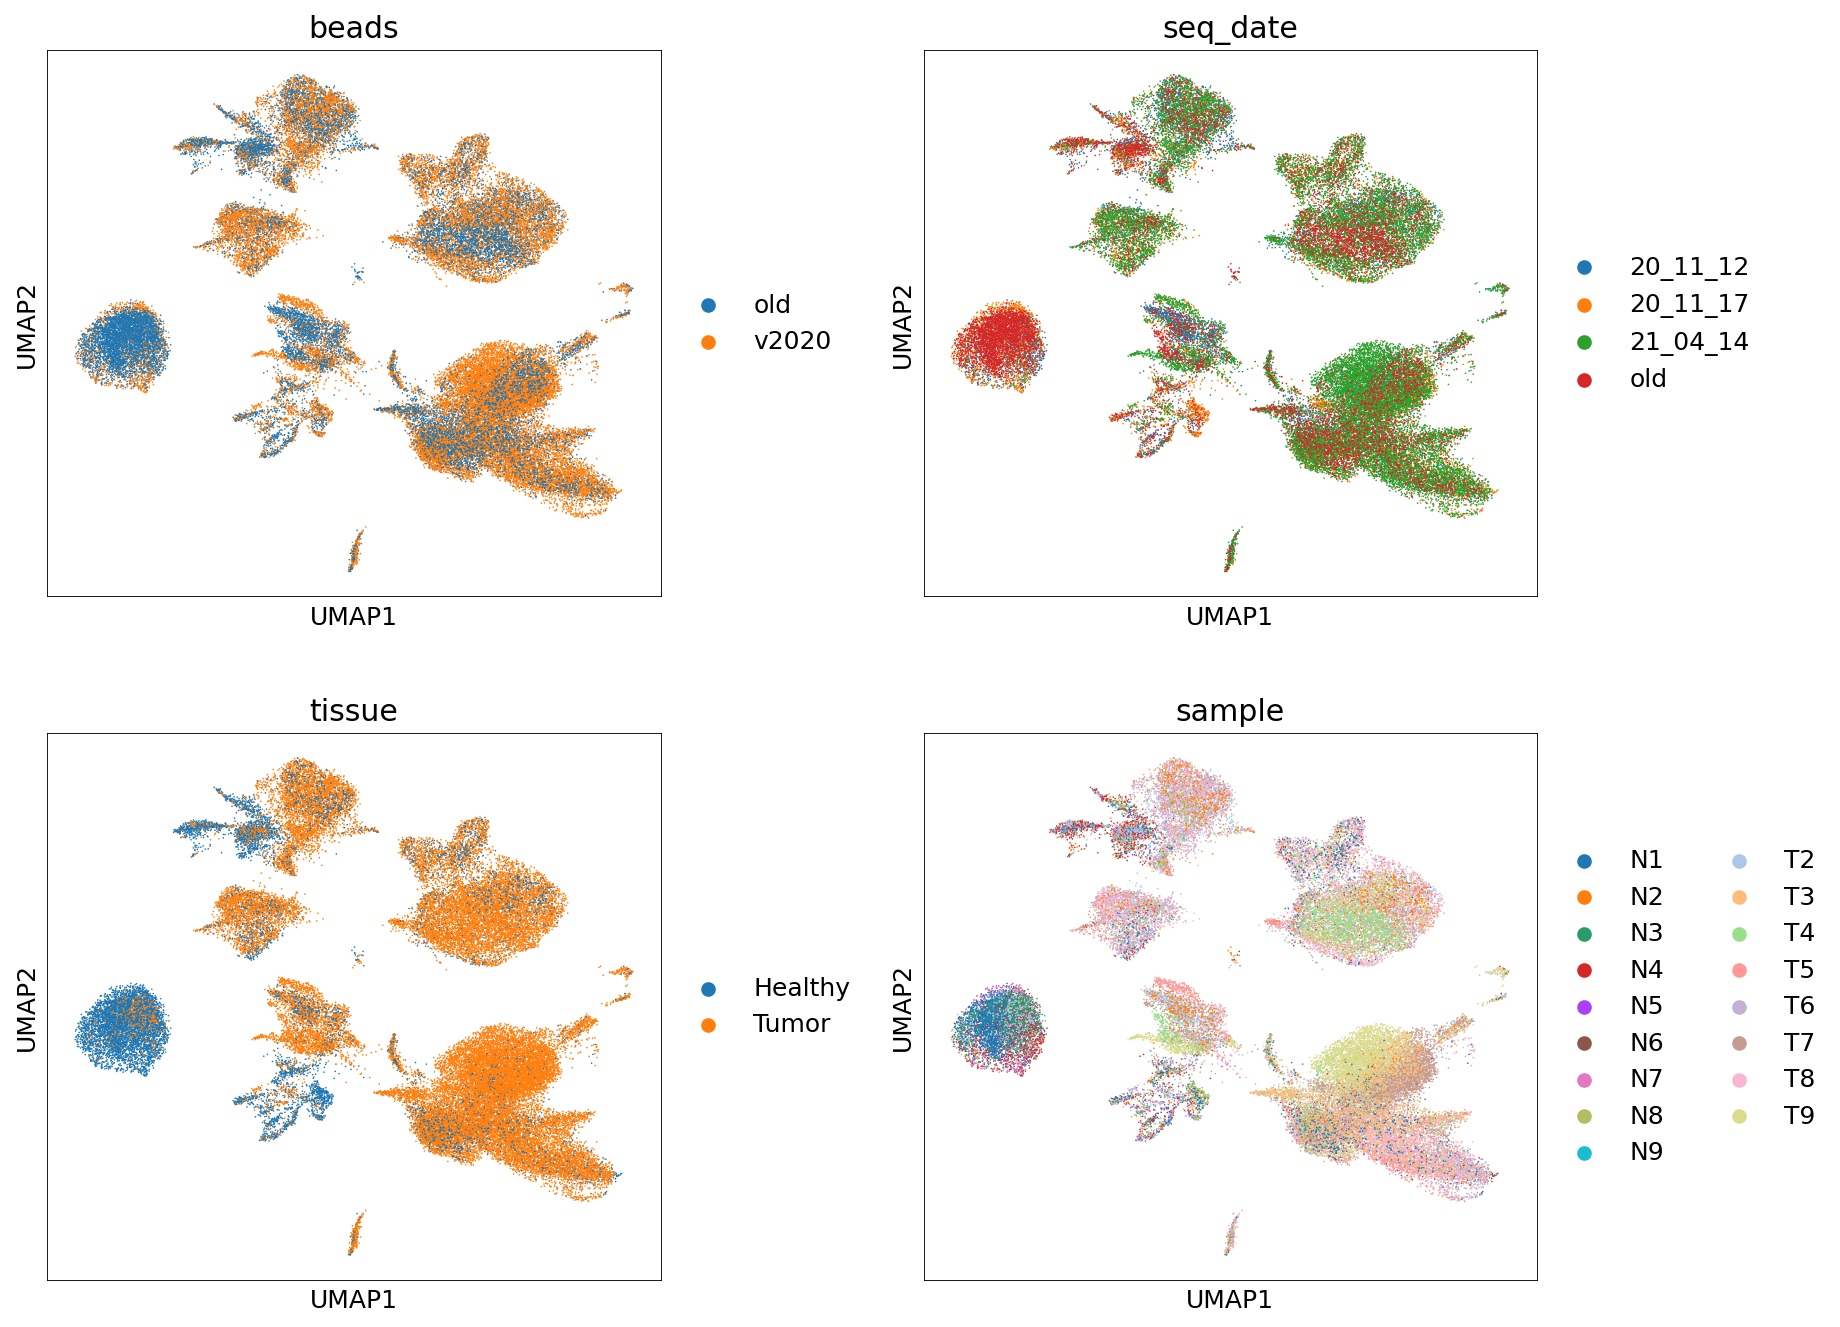

In [42]:
mpl.rcParams['figure.figsize'] = (5,5)
plt.rcParams.update({'font.size': 12})
sc.pl.umap(cdata, color = ['beads', 'seq_date', 'tissue', 'sample'], ncols = 2, wspace = 0.3, save = False)

## Choose the "optimal" UMAP parameters

In [98]:
#neighbor_list = [10, 12, 15, 20, 30]
#dist_list = [0.3, 0.5, 0.6, 0.7]


In [99]:
#for j in neighbor_list:
#    k = j
#    print(k, 'neighbors')
#    sc.pp.neighbors(cdata,k, use_rep = 'X_pca_harmony')
#    for i in dist_list:
#        sc.tl.umap(cdata, min_dist = i, random_state = 42)
#        mpl.rcParams['figure.figsize'] = (5,5)
#        sc.pl.umap(cdata, color = 'beads', use_raw = False,
#                   alpha = 0.5, s=10, title = 'neighbors = %s, dist = %s'% (j,i),
#                   save ='%s_beads_corrected, neighbors = %s, dist = %s.png'% (plot_name,j,i))
        

## Run UMAP with the chosen parameters

In [80]:
sc.pp.neighbors(cdata, 30 ,use_rep='X_pca_harmony')
sc.tl.umap(cdata, min_dist = 0.5, random_state = 42)



In [100]:
#record the parameters
pdict['neighbors'] = 30
pdict['min_dist'] = 0.5

In [101]:
plot_name = 'clean_kidney_305_15tr_25c'
pdict['plot_name']= plot_name

<span style="color:red">
Important note:

This notebook was ran multiple times with different parameters to obtain the optimal representation.
The final embedding version presented in the paper was constructed with parameters
n_neighbors = 30,
min_dist = 0.4.
   </span>

## Save UMAP for SPRING interactive viewer

In [102]:
cdata.obs.keys()

Index(['library', 'total_counts', 'pct_counts_mito', 'library2', 'sample',
       'patient', 'pT stage', 'seq_date', 'beads', 'operation', 'sex',
       'tumor size, mm', 'age', 'tissue', 'necrosis', 'doublet_score',
       'potential_doublet', 'top3pct_dbtl_score', 'top5pct_dbtl_score',
       'top10pct_dbtl_score', 'closest_JZ_kidney', 'closest_JZ_kidney_hvg',
       'removed_as_RBC', 'removed_as_dblt1', 'removed_as_dblt2', 'n_counts',
       'no_dblt_no_rbc'],
      dtype='object')

In [103]:
cdata

AnnData object with n_obs × n_vars = 50236 × 2000
    obs: 'library', 'total_counts', 'pct_counts_mito', 'library2', 'sample', 'patient', 'pT stage', 'seq_date', 'beads', 'operation', 'sex', 'tumor size, mm', 'age', 'tissue', 'necrosis', 'doublet_score', 'potential_doublet', 'top3pct_dbtl_score', 'top5pct_dbtl_score', 'top10pct_dbtl_score', 'closest_JZ_kidney', 'closest_JZ_kidney_hvg', 'removed_as_RBC', 'removed_as_dblt1', 'removed_as_dblt2', 'n_counts', 'no_dblt_no_rbc'
    var: 'mean', 'std'
    uns: 'X_lin_cptt', 'X_log_z', 'beads_colors', 'draw_graph', 'neighbors', 'pca', 'sample_colors', 'seq_date_colors', 'tissue_colors', 'umap', 'log1p'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'X_lin_cptt', 'X_log_z'
    obsp: 'distances', 'connectivities'

In [104]:
# continuous per-cell metadata
contvars = ['total_counts','pct_counts_mito', 'n_counts', 'doublet_score']

# categorical
catvars = ['library',  'library2',
           'sample', 'patient', 'pT stage', 'seq_date', 'beads', 'operation', 'sex',
           'tumor size, mm', 'age', 'tissue', 'necrosis', 'potential_doublet',
           'top3pct_dbtl_score', 'top5pct_dbtl_score', 'top10pct_dbtl_score', 'closest_JZ_kidney',
           'closest_JZ_kidney_hvg']


In [105]:
# export_spring_plot was complaining about the data format, force the right one
for contvar in contvars:
    cdata.obs[contvar] = cdata.obs[contvar].astype(float).values
    
for catvar in catvars:
    cdata.obs[catvar] = cdata.obs[catvar].astype(str).values

... storing 'library' as categorical
... storing 'library2' as categorical
... storing 'sample' as categorical
... storing 'patient' as categorical
... storing 'pT stage' as categorical
... storing 'seq_date' as categorical
... storing 'beads' as categorical
... storing 'operation' as categorical
... storing 'sex' as categorical
... storing 'tumor size, mm' as categorical
... storing 'age' as categorical
... storing 'tissue' as categorical
... storing 'necrosis' as categorical
... storing 'potential_doublet' as categorical
... storing 'top3pct_dbtl_score' as categorical
... storing 'top5pct_dbtl_score' as categorical
... storing 'top10pct_dbtl_score' as categorical
... storing 'closest_JZ_kidney' as categorical
... storing 'closest_JZ_kidney_hvg' as categorical


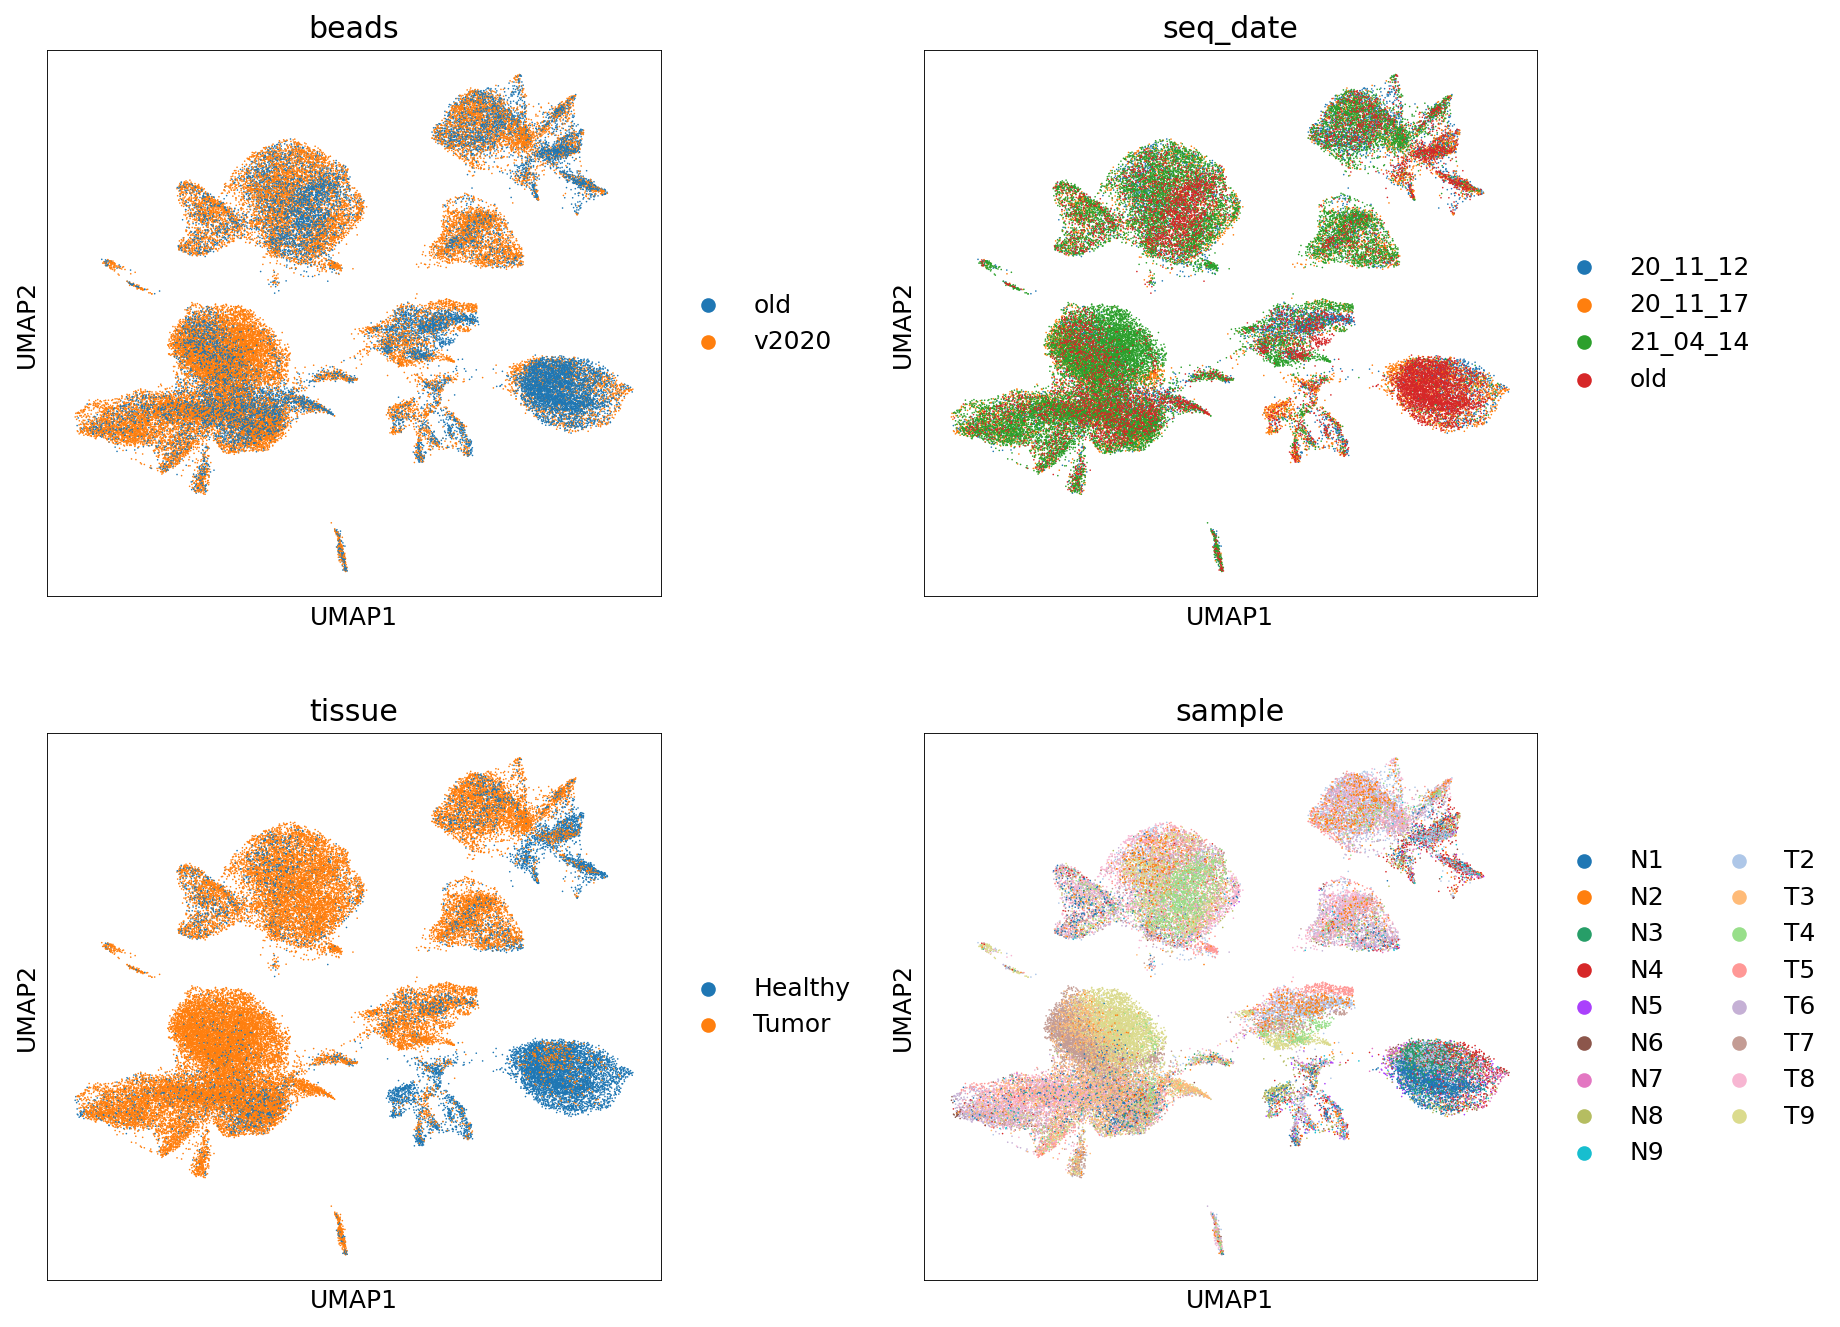

In [106]:
sc.pl.umap(cdata, color = ['beads', 'seq_date', 'tissue', 'sample'], ncols = 2, wspace = 0.3, save = False)

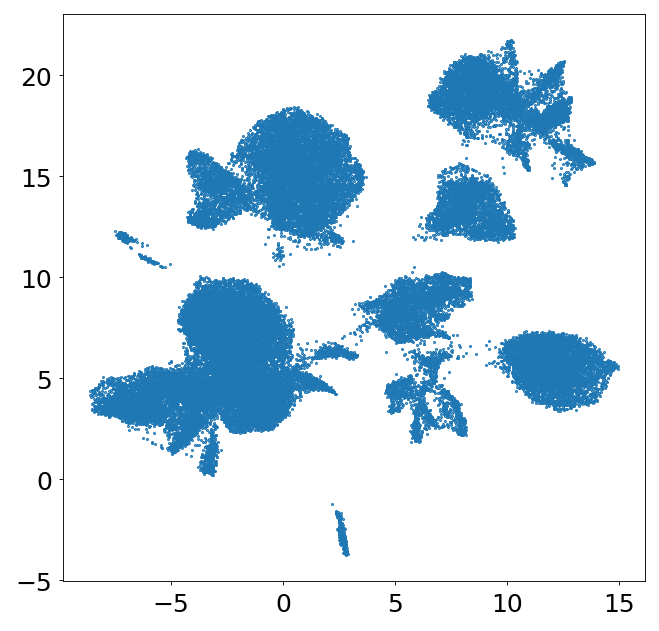

In [107]:
plt.scatter(cdata.obsm['X_umap'][:,0], cdata.obsm['X_umap'][0:,1], s = 0.2)

In [108]:
project_dir

'/Users/justina/Documents/mokslai/MAGISTRAS/MAGISTRINIS/data_and_spring/SPRING_dev-master/kidney_spring/kidney_2022'

In [109]:
sce.exporting.spring_project(cdata, project_dir = project_dir, 
                             embedding_method = 'umap', subplot_name = plot_name, cell_groupings = catvars,
                            custom_color_tracks = contvars)

Writing subplot to /Users/justina/Documents/mokslai/MAGISTRAS/MAGISTRINIS/data_and_spring/SPRING_dev-master/kidney_spring/kidney_2022/clean_kidney_305_15tr_25c


/Users/justina/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/external/exporting.py:159: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif is_categorical(adata.obs[obs_name]):
/Users/justina/opt/anaconda3/envs/sc_analysis/lib/python3.8/site-packages/scanpy/external/exporting.py:175: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif not is_categorical(adata.obs[obs_name]):


## Corrections to export properly

For some reason the plot in SPRING application is a mirror image of a plot I get plotting X_umap coordinates. Adjusting the coordinates to be portrayed properly in SPRING app. 

In [110]:
#for some reason the plot is a mirror image of X_umap coordinates, so let's make them look the same in SPRING app
embedding = cdata.obsm['X_umap']
coords = embedding - embedding.min(0)[None,:]
coords = coords * (np.array([1000, 1000]) / coords.ptp(0))[None,:] + np.array([200,-200])[None,:]
coords[:,1] = coords[:,1]*(-1)

In [111]:
#subplot path
subplot_path = project_dir + '/' + plot_name
subplot_path

'/Users/justina/Documents/mokslai/MAGISTRAS/MAGISTRINIS/data_and_spring/SPRING_dev-master/kidney_spring/kidney_2022/clean_kidney_305_15tr_25c'

In [112]:
#saving the new coordinates to subplot folder
np.savetxt('%s/coordinates.txt'%(subplot_path),
               np.hstack((np.arange(len(embedding))[:,None], coords)),
               fmt='%i,%.6f,%.6f')

In [113]:
#check in SPRING if looks the same as X_umap plot, it does now

In [114]:
#save plot parameters
rz.save_stuff(path=project_dir+'/'+plot_name+'/params',stuff=pdict)


In [115]:
#save the cdata
fname = 'backups_JZ_2022/%s_batch_corrected_%dx%d_%s.h5ad'%(plot_name, cdata.shape[0],cdata.shape[1],rz.now())
fname                                                       

'backups_JZ_2022/clean_kidney_305_15tr_25c_batch_corrected_50236x2000_220315_12h28.h5ad'

In [ ]:
#cdata.uns.pop('spring_params') #for some reason adata.write does not allow dict of dicts
cdata.uns

In [117]:
cdata.write(fname)

In [119]:
#okay, apparently exporting spring plot did not work correctly and did not save the cell filter
cell_ix = np.arange(len(pdict['cell_mask']))[pdict['cell_mask']]


In [122]:
np.savetxt(subplot_path + '/cell_filter.txt', cell_ix, fmt='%i')
np.save(subplot_path + '/cell_filter.npy', cell_ix)

In [123]:
#also noticed the colorbar saturation levels are not right because my adata raw is not normalized, however
#I want to keep it that way so overwriting manually

In [124]:
adata.X.sum(axis=1)

matrix([[10000.001],
        [10000.   ],
        [10000.001],
        ...,
        [ 9999.999],
        [ 9999.999],
        [ 9999.999]], dtype=float32)

In [126]:
E = adata.X.tocsc() #normalized

In [127]:
from scanpy.external.exporting import (_write_color_tracks,
                                 _get_color_stats_genes,
                                 _get_color_stats_custom,
                                 _write_color_stats
                                 )

In [128]:
gene_list = adata.var_names.values

In [129]:
continuous_extras = {}
for obs_name in contvars:
       continuous_extras[obs_name] = np.array(cdata.obs[obs_name])

In [130]:
# Create and write a dictionary of color profiles to be used by the visualizer
color_stats = {}
color_stats = _get_color_stats_genes(color_stats, E[cell_ix, :], gene_list)
color_stats = _get_color_stats_custom(color_stats, continuous_extras)
_write_color_stats(subplot_path + '/color_stats.json', color_stats)